# Transfer Learning and Data Augmenation
In this colab we will talk about how to use a learned model, and transfer weights to use it for our problem. After that we will talk about how to augment into our dataset when we have small traning set.

## Open Google Drive

To mount your drive inside "gdrive" folder
1. Run the bellow cell
2. You'll see a link, click on link, then allow access, copy the code that pops up, paste it at "Enter your authorization code:".

In [1]:
# Open google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Change directory in google drive
import os

demo_folder = '/content/gdrive/My Drive/cmpsc448/dl_demo'
if not os.path.exists(demo_folder):
    os.mkdir(demo_folder)

os.chdir(demo_folder)

In [3]:
%%bash
pwd
ls -ltrh

/content/gdrive/My Drive/cmpsc448/dl_demo
total 0


This cell will download data and extract images. **Run this cell if the data is not in the folder.**

In [0]:
%%bash
# install axel to download data
apt install -y axel
echo "Download data started"
axel --quiet "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/3362/31148/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1581124636&Signature=WO2INf%2BqK24SxQvRYv1Ld4YF1tTApjRIMnlSGb9%2F32YRI7ROq3mTNKr6GGctfregfJ%2FiQYHe8j9npffsG0Q%2F9M9JkfKsyjGEP2y0X3jY3P8OJ0y4xnyR0n04oIL7IT5h4koBsOYViQBZCO7GJDboO4h7KbP4XmV4%2FePD%2BHEt7nuElPXP7xVaqmPwYb%2BXMNAT1a9yYceWYL26eOLuRy2vm%2Bv1EQySap0l7PX1ZQq1gMqcL%2BtdAu9nHECg1rg3m%2BX%2BQ4xbY36NGMcj4Dno3YBRbLDiItimKERfNTcJJ%2F1c3hyp7iMAlJngISJgGDzH%2B8HC3TQmC9LoAV5MgNK%2BNv35Yg%3D%3D&response-content-disposition=attachment%3B+filename%3Ddogs-vs-cats.zip"
echo "Donwload data ended"
unzip -q dogs-vs-cats.zip
echo "Unzip train data"
unzip -q train.zip
echo "Unzip test data"
unzip -q test1.zip
echo "Data section completed"

mkdir -p ./data/train/cats
mkdir -p ./data/train/dogs

mkdir -p ./data/validation/cats
mkdir -p ./data/validation/dogs

set_name='train'
for folder_name in 'cat' 'dog'; do
	counter=1
	for index in $(seq 0 1 999); do
		new_index=$(printf "%03d" ${counter})
		cp train/${folder_name}.${index}.jpg data/${set_name}/${folder_name}s/${folder_name}${new_index}.jpg
		counter=$((counter+1))
	done
done

set_name='validation'
for folder_name in 'cat' 'dog'; do
	counter=1
	for index in $(seq 1000 1 1399); do
		new_index=$(printf "%03d" ${counter})
		cp train/${folder_name}.${index}.jpg data/${set_name}/${folder_name}s/${folder_name}${new_index}.jpg
		counter=$((counter+1))
	done
done

ls -1 ./data/train/cats/ | wc -l | { read cnt; echo "Number of train image for cat is $cnt"; }
ls -1 ./data/train/dogs/ | wc -l | { read cnt; echo "Number of train images for cat is $cnt"; }
ls -1 ./data/validation/cats/ | wc -l | { read cnt; echo "Number of validation images for cat is $cnt"; }
ls -1 ./data/validation/dogs/ | wc -l | { read cnt; echo "Number of validation images for dog is $cnt"; }

In [0]:
%%bash
ls -ltrh

total 2.3G
-rw------- 1 root root  87K Dec 11 04:17 sampleSubmission.csv
-rw------- 1 root root 272M Dec 11 04:18 test1.zip
-rw------- 1 root root 544M Dec 11 04:18 train.zip
-rw------- 1 root root 813M Feb  5 15:41 dogs-vs-cats.zip
drwx------ 2 root root 4.0K Feb  5 20:22 test1
drwx------ 2 root root 4.0K Feb  5 20:22 data
drwx------ 2 root root 4.0K Feb  5 20:23 train
-rw------- 1 root root 2.0K Feb  5 20:23 rename_and_mv.bash
-rw------- 1 root root 528M Feb  6 19:36 vgg16_weights.h5
-rw------- 1 root root  63M Feb  7 00:11 bottleneck_features_train.npy
-rw------- 1 root root  26M Feb  7 00:11 bottleneck_features_validation.npy
-rw------- 1 root root 8.1M Feb  7 00:12 bottleneck_fc_model.h5
-rw------- 1 root root 4.7M Feb  7 04:33 first_try.h5


In [28]:
# import cell
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend, optimizers
from tensorflow.keras import applications
import numpy as np
import matplotlib.pyplot as plt

2.1.0
2.2.4-tf


In [9]:
if 'COLAB_TPU_ADDR' in os.environ: 
    print('Connected to TPU') 
elif tf.test.gpu_device_name() is not '': 
    print('Connected to GPU ' + tf.test.gpu_device_name())
else:
    print('Neither connected to a TPU nor a GPU')

Connected to GPU /device:GPU:0


## Simple CNN

The code below is a simple CNN to classify cat and dog images. To train this CNN, we use 2000 images as our training, and 800 images as our validation.

The dataset was download from [Kaggle website](https://www.kaggle.com/c/dogs-vs-cats/overview) and cleaned.

In [10]:
img_width, img_height = 150, 150

train_data_dir = './data/train'
validation_data_dir = './data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
number_of_epochs = 50
batch_size = 16

if backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',  
              metrics=['accuracy'])

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

model.summary()

model.fit(train_generator,
          steps_per_epoch = (nb_train_samples // batch_size),
          epochs = number_of_epochs,
          validation_data = validation_generator,
          validation_steps = (nb_validation_samples // batch_size))

model.save_weights('./first_try.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

## Transfer Learning
**Using bottelneck featuers of a pre-trained network**

A more refined approach would be to leverage a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

VGG16 architecture, pre-trained on the ImageNet dataset. Because the ImageNet dataset contains several "cat" classes (persian cat, siamese cat...) and many "dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem. In fact, it is possible that merely recording the softmax predictions of the model over our data rather than the bottleneck features would be enough to solve our dogs vs. cats classification problem extremely well. However, the method we present here is more likely to generalize well to a broader range of problems, including problems featuring classes absent from ImageNet.

The VGG16 architectuer is:

![](https://blog.keras.io/img/imgclf/vgg16_original.png)

We will keep everything up to the fully connected layer. Now, we will learn this model for our train and validation data set and keep the output separately. Then, we will try to learn a fully connected layer, and when we have that fully connected layer we can put it on top of our model. After this, we can test our model for test data and check how it is working.

In [22]:
img_width, img_height = 150, 150

top_model_weights_path = './bottleneck_fc_model.h5'
train_data_dir = './data/train'
validation_data_dir = './data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    model = applications.VGG16(weights='imagenet', include_top=False)
    
    model.summary()

    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    
    bottleneck_features_train = model.predict(generator)
    
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(validation_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    
    bottleneck_features_validation = model.predict(generator)
    
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)


def train_fully_connected():

    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))

    train_labels = np.array([0] * (nb_train_samples // 2) + 
                            [1] * (nb_train_samples // 2))

    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array([0] * (nb_validation_samples // 2) + 
                                 [1] * (nb_validation_samples // 2)
                                 )

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    model.summary()

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    
    model.save_weights(top_model_weights_path)

save_bottlebeck_features()
train_fully_connected()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Fine-Tune a Model

**Fine-tuning the top layers of a a pre-trained network**

For making the result better we can use a technique to fine-tune our model. In the fine-tunning, we update wight of our model a little to make it work better for our specific task. For example a model which was trained on the  Imagenet has the purpose to make difference between many different classes (for example, kitchen and dog). Since our task is different and we only have two class 'cat' and 'dog'; therefore, we can re-traing the Nerual Network of VGG16 on our new dataset and make smalll changes on the weights, such that, we get better performance in our taks. 

In this example to fine-tune the model, first thing first, we will load the convolution part of the VGG16. Second thing second, we will freeze the first 4 convolution block. Third thing third, we will run the network over our train data set and update wights of the last convolution layer and the fully connected layer that we added in the previous part.

Therefore, the architectuer will be:

![](https://blog.keras.io/img/imgclf/vgg16_modified.png)




In [39]:
weights_path = './vgg16_weights.h5'
fully_connected_model_weights_path = './bottleneck_fc_model.h5'
train_data_dir = './data/train/'
validation_data_dir = './data/validation'

img_width, img_height = 150, 150

nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16


input_tensor = Input(shape=(img_height, img_width, 3))
convol_model = applications.VGG16(weights='imagenet', include_top=False, 
              input_tensor=input_tensor)

fulycn_model = Sequential()
fulycn_model.add(Flatten(input_shape=convol_model.output_shape[1:]))
fulycn_model.add(Dense(256, activation='relu'))
fulycn_model.add(Dropout(0.5))
fulycn_model.add(Dense(1, activation='sigmoid'))

fulycn_model.load_weights(fully_connected_model_weights_path)

new_model = Sequential()

for layer in convol_model.layers:
    new_model.add(layer=layer)

for layer in fulycn_model.layers:
    new_model.add(layer=layer)

for layer in new_model.layers[:15]:
    layer.trainable = False

for layer in new_model.layers:
    print(layer, layer.trainable)

new_model.summary()

new_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size, 
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

new_model.fit(train_generator,
              steps_per_epoch = nb_train_samples // batch_size,
              epochs=epochs,
              validation_data = validation_generator,
              validation_steps = nb_validation_samples // batch_size)


<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe2596d0e80> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe2596ba4e0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe2596baef0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe2596baf28> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe2596c6fd0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe2596c7ef0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe2596c74e0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe2596d7fd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe25765ac88> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe25765ac50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe257661160> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x

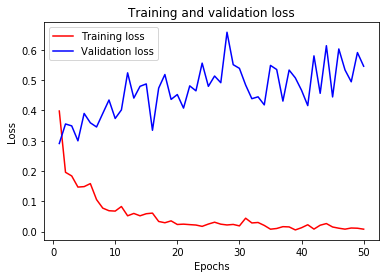

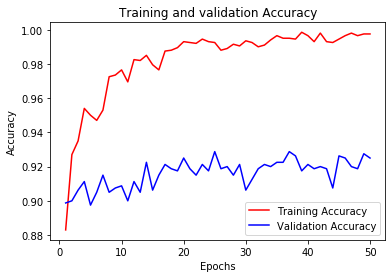

In [53]:
history = new_model.history

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


history_dict = history.history
accu_values = history_dict['accuracy']
val_accu_values = history_dict['val_accuracy']

plt.plot(epochs, accu_values, 'r', label='Training Accuracy')
plt.plot(epochs, val_accu_values, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Found 800 images belonging to 2 classes.


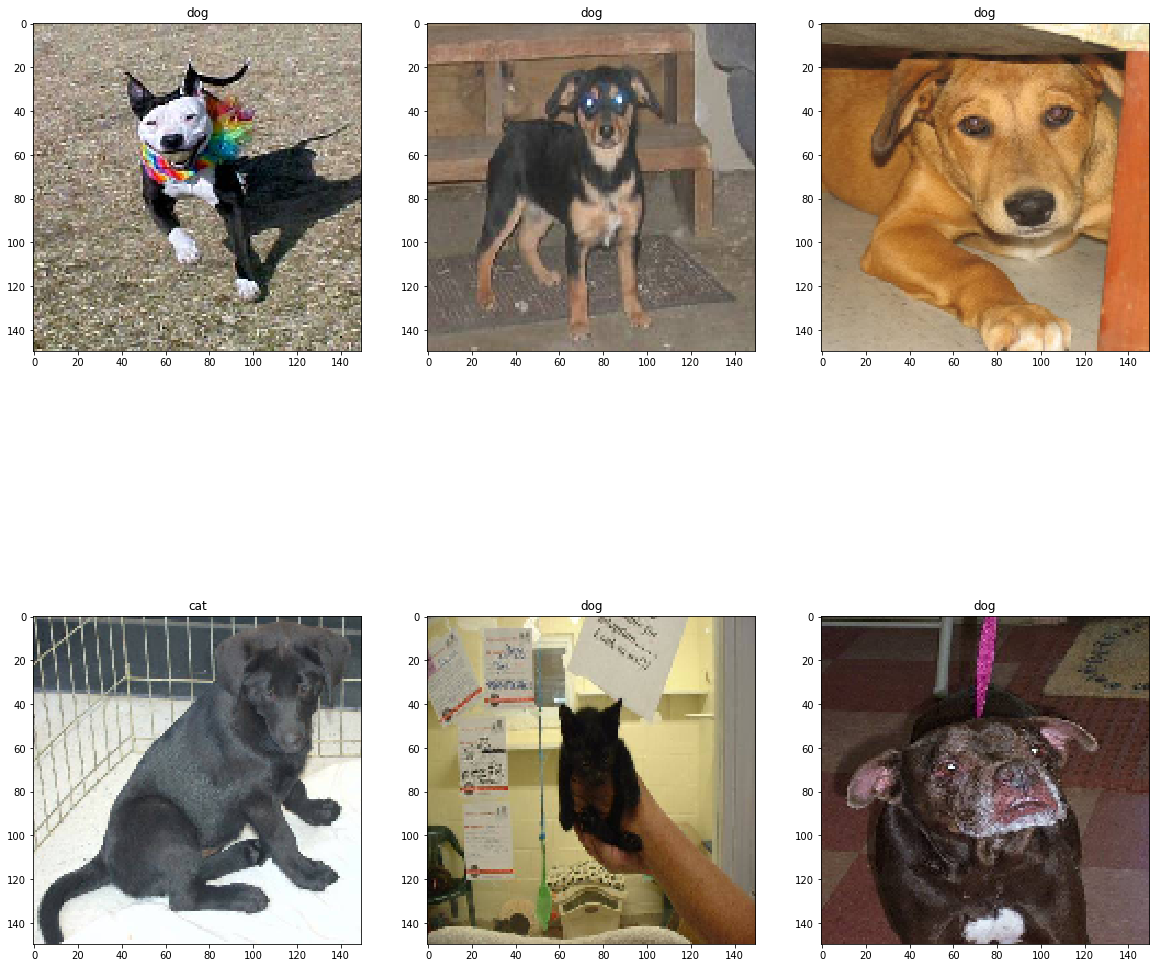

In [80]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
columns = 3

i = 0
text_labels = []
plt.figure(figsize=(20,20))
for batch in test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=1,
                                                        class_mode='binary'):
    pred = new_model.predict(batch)
    if pred > 0.5:
        text_labels.append('dog')
    else:
        text_labels.append('cat')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title(text_labels[i])
    img = batch[0]
    imgplot = plt.imshow(img[0])
    i += 1
    if i % 6 == 0:
        break

plt.show()